# Laserscanning - Exercise 7

#### Please upload the implemented solutions until <u>09.01.2023</u> to the studip folder of your group. The file should follow this format:
##### EX07_Group_XX.ipynb (e.g. EX07_Group_04.ipynb)
(In case you need to upload additional files, please also upload them using the same schema, e.g. EX07_Group_04.zip)

|

# Classification - Random Forest

You will need the lecture script No. 8 “Classification” and 9 “Classification II” (download: Stud.IP) to complete this assignment.

## Classification by Random Decision Forests

Random Decision Forests use several decision trees to classify objects using specific attributes. In this exercise you will use actual data from our LiDAR mobile mapping van. You will learn how to label data, program the extraction of features similar to the ones shown in the lecture, and train your classifier based on your features. 

# A first glimpse at the data

## The scan strip representation.
We put the raw data of the scanner into a 'scan strip', an array of measurements. As shown in the lecture, each column of the scan strip is one rotation of the scanner. Since the scanner emits about 3000 measurements per full rotation, the scan strip has 3000 rows. Since the mirror rotates with 100 revolutions/s, it has 100 columns for each second it was running, i.e. a 10 second recording will produce a 3000 x 1000 scan strip.

In a scan strip, we can store different 'channels'. For example, we can store x, y, z in separate channels. More precisely, in our case, the scan strips have 5 channels: x, y, z, reflectance, rel_height. Therefore, our scan strips will have dimensions: 5 x 3000 x columns. So it is a 3-dimensional array, also known as tensor.

In [2]:
import numpy as np

scanstrip_name = "210903_123403_Scanner_1"
scanstrip_data = np.load(scanstrip_name + ".npy")
print("The dimensions of the data are:", scanstrip_data.shape)

The dimensions of the data are: (5, 3000, 1360)


So we know our scanner ran for 13.6 seconds to produce this scan strip. Using matplotlib we can inspect the data. Remember channel 3 is reflectance, so scanstrip_data\[3\] is the reflectance array.

In [3]:
import matplotlib.pyplot as plt
# You can modify the following line to adjust the (width, height) of the plots (supposed to be in inches).
plt.rcParams['figure.figsize'] = (16, 12)
# You may play with vmin, vmax to stretch the color scale differently.
plt.imshow(scanstrip_data[3], cmap="jet", interpolation="nearest", vmin=-1500, vmax=0);

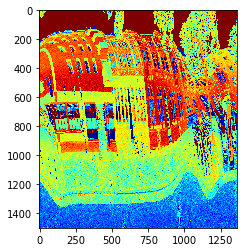

In [4]:
# Here is a (larger) view of the upper part only.
plt.imshow(scanstrip_data[3,:1500], cmap="jet", interpolation="nearest", vmin=-1500, vmax=0);

We used the color map 'jet' here, which goes from blue (low values) to red (high values). You may also use other color maps, a list of which you will find [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

Just to show you how you can work with the channels, let us plot the distribution of the reflectance channel. This may be interesting to select an appropriate vmin, vmax range for the plot. The distribution can be visualized using a histogram.

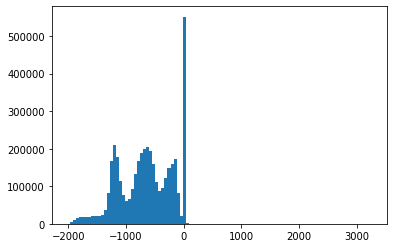

In [5]:
plt.hist(scanstrip_data[3].flatten(), bins=100);

We can see that the reflectivity values are mostly from -2000 to 0, but apparently, there are also very few values which are larger, in the +3000 range.

However, we see also a large peak at 0, which is actually an artefact. Because not every emitted laser pulse leads to a valid return, we will have invalid measurements. In order to indicate such a measurement, we used the following convention: if x=0 and y=0 and z=0, the measurement is invalid. The problem is that we did not filter out the invalid measurements before computing the histogram -- this is where the large peak at zero comes from.

We will now do so, and create a binary mask of all valid measurements, called `valid_mask`, then repeat the histogram computation. The peak at zero disappears. What remains are three peaks, which loosely correspond to different parts in the scene.

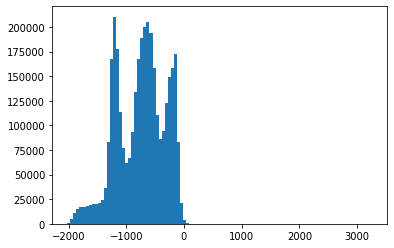

In [6]:
# Compute a binary mask of valid pixels.
valid_mask = np.logical_or(np.logical_or(scanstrip_data[0]!=0.0, scanstrip_data[1]!=0.0), scanstrip_data[2]!=0.0)
# Repeat the histogram computation, constrained to the valid measurements.
plt.hist(scanstrip_data[3][valid_mask], bins=100);

## The point cloud representation
The scan strip represents the 'raw data', however we would also often like to view the data in object space. To convert the scan strip to a point cloud, you may use the provided function `write_ply_file()`. This will produce a point cloud representation which can then be viewed using existing tools. We will use the tool 'CloudCompare' which is freely available for all major platforms.

In [7]:
# First execute this cell.
from support_functions import write_ply_file
write_ply_file(scanstrip_data, ply_filename = "demo.ply")

Then, load the file `demo.ply` into CloudCompare. When loading, make sure to load `reflectance` and `rel_height` as scalar fields. After loading, you should see something like the following. You may select different scalar fields for visualization and play with the histogram in the lower left corner (note it is the same histogram which we produced above in this notebook).
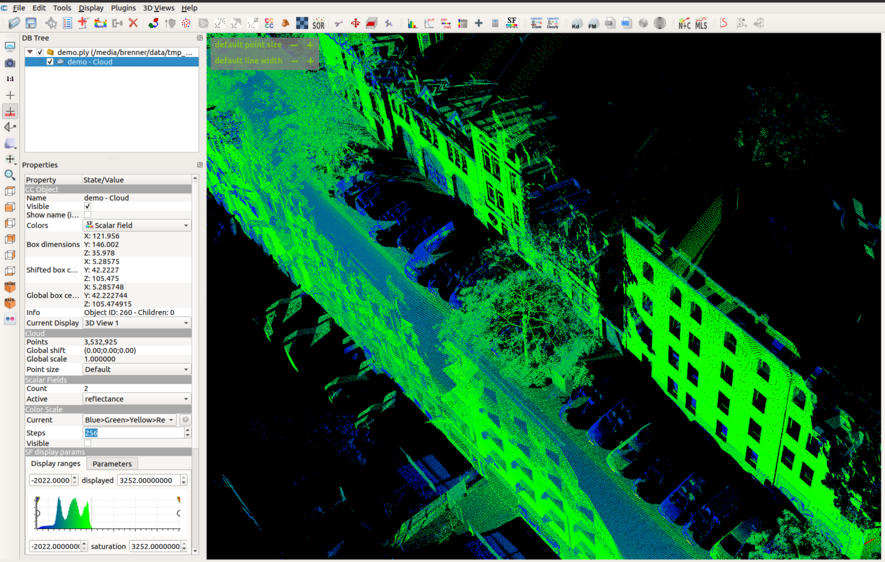

# Training a classifier
## First, we need labels
In order to train a classifier in a supervised setting, we need training data. Therefore, we will label points in 3D, using CloudCompare.
We will do so by using a 'scalar field' in CloudCompare which is a label number. We will use the following label number convention:

| Label number | Class |
| :--- | :--- |
| 0 | Unlabeled |
| 1 | Ground |
| 2 | Building |
| 3 | Tree |
| 4 | Car |


As a starting point, the following code will produce a PLY file with some initial labels.

In [8]:
# Generate a mask of labels.
demo_labels = np.zeros(scanstrip_data.shape[1:], dtype=np.float32)
demo_labels[1032:1839, 234:924] = 1  # Set some ground.
demo_labels[260:740, 411:827] = 2  # Building.
demo_labels[0:260, 950:1240] = 3  # Tree.
a_few_cars_mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(
    scanstrip_data[0]>2.1, scanstrip_data[0]<8.0),
    scanstrip_data[1]>9.85), scanstrip_data[1]<20.26),
    scanstrip_data[2]>97.55), scanstrip_data[2]<100.0)
demo_labels[a_few_cars_mask] = 4  # Car.
# Now write a PLY file which contains row, column and label.
write_ply_file(scanstrip_data, feature_list = [("label", demo_labels)], write_row_col = True,
               ply_filename = "demo_labels.ply")

Now open `demo_labels.ply` in CloudCompare, and **make sure you load at least the three scalar fields 'label', 'strip_row', and 'strip_column'**. Select 'label' as the scalar field to visualize. It should look like the following, the original scene labeled with some ground, building, tree, and cars. The majority of points is still unlabeled (blue in the image).
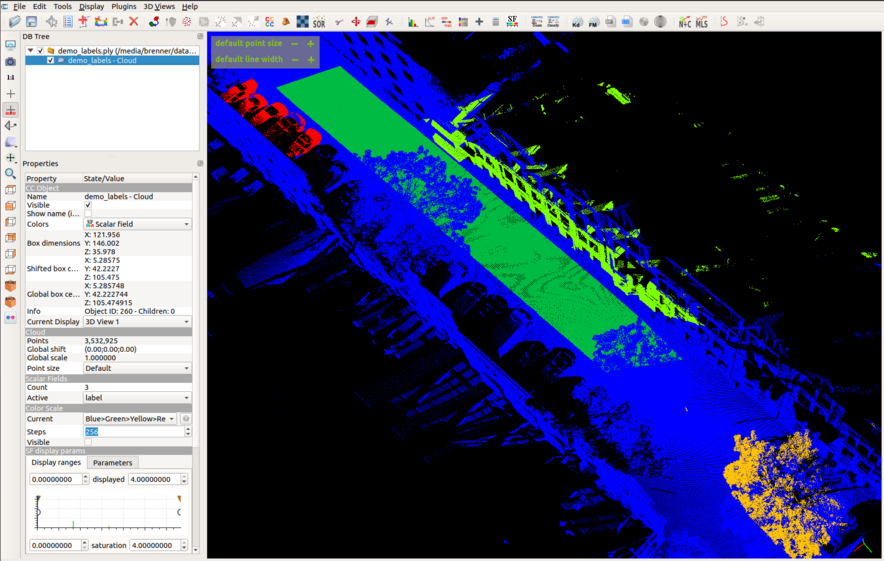

We pretend to do some labeling in CloudCompare (but actually defer that to later). Next, save the labeling result as PLY file, using the filename `ground_truth.ply`.

Make sure that:
- when you *load* the data into CloudCompare, select at least 'label', 'strip_row', and 'strip_column', as otherwise, the data can't be read back, and
- when you *save* the data from CloudCompare to disk, save it as 'PLY' (binary), with the filename `ground_truth.ply`.

Now we load back the labels from `ground_truth.ply`. We use the provided function `read_back_labels_from_ply_file()`. If this breaks, check the remarks above.

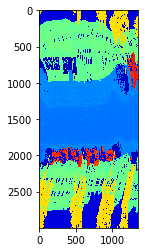

In [9]:
from support_functions import read_back_labels_from_ply_file
r, c, l = read_back_labels_from_ply_file("ground_truth.ply")
ground_truth_labels = np.zeros(scanstrip_data.shape[1:], dtype=np.int16)
ground_truth_labels[r,c] = l
# Create a simple visual overlay by adding a little bit of 'reflectance' to the class label.
plt.imshow(ground_truth_labels + scanstrip_data[3]*0.0002, cmap="jet", interpolation="nearest");

## Now, we can train a classifier!
As promised, we will use a random forest. We will have to do the following steps:
- **filter**: we want to use only points which are labeled,
- **scale**: a usual method to improve classification is to re-scale the attributes to have zero mean and unit variance,
- **split**: partition the ground truth data into training and test parts (the hold back approach),
- **train**: train the random forest classifier.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Filter: use only data which has been labeled (i.e., label > 0).
labeled_mask = ground_truth_labels > 0
X, y = scanstrip_data[:,labeled_mask].T, ground_truth_labels[labeled_mask]

# Scale: scale all attributes.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and test: 30% test size.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Train.
# n_estimators is the number of trees. Set verbose to a smaller number if it is too verbose.
clf = RandomForestClassifier(n_estimators=16, criterion="entropy", n_jobs=-1, verbose=2)
clf.fit(X_train, y_train);  # The actual training process.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 16building tree 2 of 16building tree 3 of 16

building tree 4 of 16

building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   18.2s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   19.6s finished


## Next, we can report on the performance

In [11]:
clf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.3s finished


0.9995175472100157

The score looks great! Check the measures we learned in the lecture. First, the confusion matrix.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.3s finished


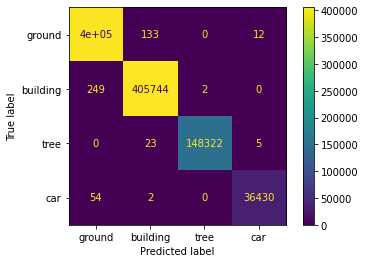

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
     precision_score, recall_score, f1_score
class_names = ["ground", "building", "tree", "car"]
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot();

Report precision, recall, and F1 measure.

In [13]:
def report_prec_recall_f1(true_y, predicted_y, classes, classnames):
    precision = precision_score(true_y, predicted_y, average=None,
                                labels=classes)
    recall = recall_score(true_y, predicted_y, average=None,
                          labels=classes)
    f1 = f1_score(true_y, predicted_y, average=None, labels=classes)
    print("%15s%10s%10s%10s" % ("Class", "Precision", "Recall", "F1 score"))
    for t in zip(classnames, precision, recall, f1):
        print("%15s%10.3f%10.3f%10.3f" % t)
report_prec_recall_f1(y_test, y_pred, clf.classes_, class_names)

          Class Precision    Recall  F1 score
         ground     0.999     1.000     0.999
       building     1.000     0.999     0.999
           tree     1.000     1.000     1.000
            car     1.000     0.998     0.999


All that looks perfect!

## What did we do wrong?
Our result is too good to be true! Why is this the case? Remember in the lecture, we said that using X, Y, Z will usually be not a good idea, because all that happens is that the classifier learns the *location* of the classes in object space, which will not be useful at all when it comes to generalization.

How can we check that? We can apply the classifier to the entire scan strip. Note that by doing so, we apply it to data that has not been labeled yet, but also to the part of the data that has already been labeled.

In [14]:
# Do the prediction for the entire scan strip.
X_all = scanstrip_data[:,valid_mask].T
X_all = scaler.transform(X_all)  # Transform using the scaler from above.
y_all_pred = clf.predict(X_all)
predicted_labels = np.zeros(scanstrip_data.shape[1:], dtype=np.uint16)
predicted_labels[valid_mask] = y_all_pred

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    1.0s finished


View the result as a scan strip:

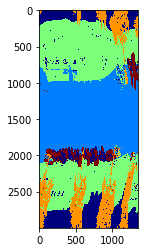

In [15]:
plt.imshow(predicted_labels, cmap="jet", interpolation="nearest");

It seems that all it has learned are regions in space. However, that makes sense, as the classifier learns whatever criterion is useful to separate the training data.

If you would like to have a 3D view: run the following cell, then load `predicted_labels.ply` into CloudCompare, and visualize the scalar field 'label'.

In [15]:
# Write a PLY file with predicted_labels.
write_ply_file(scanstrip_data, feature_list = [("label", predicted_labels)],
               ply_filename = "predicted_labels.ply")

# Computing features
## First part: compute features for a local neighborhood of points
We will now compute features which indicate the local structure around each point, similar to the features presented in the lecture. In particular, for eacht point, we will compute:
- the three attributes `linear`, `planar`, and `scatter`,
- `abs_eve0_z`, the absolute value of the z component of eigenvector 0 (the eigenvector belonging to the smallest eigenvalue),
- `abs_eve2_z`, the absolute value of the z component of eigenvector 2 (belonging to the largest eigenvalue).

As you remember from the lecture, we will have to:
- fill a scatter matrix,
- compute the eigenvalues and eigenvectors from this,
- then order the eigenvalues in increasing order (*and* order the eigenvectors accordingly),

this part will be realized by the function `compute_pca()`. Then, we will have to use this result to
- compute `linear`, `planar`, `scatter` from the eigenvalues,
- `abs_eve0_z` from the 2nd component of eigenvector 0, and
- `abs_eve2_z` from the 2nd component of eigenvector 2.

Implement the first part:

In [16]:
def compute_pca(xyz):
    """Given an array of x, y, z coordinates of shape n x 3, return the eigenvalues and eigenvectors.

    The eigenvalues must be returned as an ordered array, smallest eigenvalue first.    
    The eigenvectors must be returned as a matrix, where the eigenvectors are the columns of the matrix.
    The columns must be sorted according to the eigenvalues, i.e., the first first column must be the
    eigenvector belonging to the smallest eigenvalue.
    """
    # Remember to first compute reduced coordinates (reduced by the center of mass) from the passed xyz array.
    # To sort the eigenvalues and eigenvectors properly, you could have a look at np.argsort().
    
    ### BEGIN SOLUTION
    
    ev_list = list()
    eve_list = list()
    mean_xyz = np.mean(xyz)
    list_mxyz =  mean_xyz.tolist()
    c_xyz = xyz - mean_xyz
    covariance_mat = c_xyz.T @ c_xyz  #covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eig(covariance_mat)    
    order = np.argsort(eigen_vals) #Returns the indices that would sort an array.
    
    for i in order:
        ev_list.append(eigen_vals[i])
        eve_list.append(eigen_vecs[i])
        ev = np.array(ev_list) 
        eve = np.array(eve_list)
        pass
    
    ### END SOLUTION

    # Return eigenvalues (array of values) and eigenvectors (matrix of column vectors).
    return ev, eve

<u>Please explain your code here:</u>

With help of this function we can compute the eigenvalue and eigenvector for 'xyz', and the eigenvalues are sorted, eigenvectors correspond to eigenvalues.
At first we should compute the center of mass from xyz, and then use the original xyz minus the center of mass from xyz to get the reduced coordinates, we use transposed reduced coordinates @ reduced coordinates to get the dot product, it is also called covariance matrix.
We can use 'np.linalg.eig()' compute the eigenvalue and eigencevtor, but the eigenvalues are not sorted, so we can use 'np.argsort()' sort the eigenvalue. Through the result of sorted eigenvalue we can also sort the eigenvector.




Now, implement a function that takes the xyz point list and computes all features, `linear`, `planar`, `scatter`, `abs_eve0_z`, `abs_eve2_z`, and returns this as a numpy array. (Note this will have to call `compute_pca()`.)

In [17]:
def compute_features(xyz):
    """Given an array of x, y, z coordinates, compute features similar to the ones in the lecture.

       Returns: linear, planar, scatter, abs_eve0_z, abs_eve2_z, as a 1D numpy array.
    """
    ### BEGIN SOLUTION
    
    ev, eve = compute_pca(xyz)
    l = (ev[2]-ev[1])/ev[2]
    p = (ev[1]-ev[0])/ev[2]
    s = (ev[0]/ev[2])
    abs_eve0_z = abs(eve[0][2])
    abs_eve2_z = abs(eve[-1][2])
    
    ### END SOLUTION

    return np.array((l, p, s, abs_eve0_z, abs_eve2_z))

<u>Please explain your code here:</u>

ev and eve are the sorted eigenvalue and eigenvector.
ev[0] is the smallest value of eigenvalue, ev[2] is the biggest value.
l means Linear, p means planar, s means scatter.
Those three functions compute the feature of linear, planar and scatter. abs_eve0_z and abs_eve2_z means the 2nd component of eigenvector 0 and eigenvector 2.



<u>Please give a short explanation of the features here:</u>

The feature of Linear is 1D, so we should use the biggest eigenvalue to show the feature, and eigenvalue[2] of linear is much bigger than eigenvalue[0] and eigenvalue[1] of linear, so that eigenvalue[2] plays an important roll.

The feature of planar is 2D. As we konwn the eigenvalue[0] is the smallest value, so we should use the much bigger eigenvalues than eigenvalue[0] to show the feature of planar, so that the eigenvalue[1] and eigenvalue[2] play important roll.

The feature of Scatter is 3D, if we want to show the feature of scatter, eigenvalues can not obviously bigger or smaller than each other. So the eigenvalues of scatter are almost same.

abs_eve0_z and abs_eve2_z are the eigenvectors, which are belong to the smallest eigenvalue and biggest eigenvalue.

We use the vector abs_eve0_z dot multiply z-axis. According to the result of scalar product we can get differet features. For the road surface, the result should be close to 1. For the facadeds, the result should be close to 0. For the overhanging balconies, the result should be close to -1.

Similarly to last step, we compute the scalar product with z-axis, but the goal of this step is different from last step. From this result we can distinguish upright linear structures from horizontal ones. The abs_eve0_z is the normal vector of the plane, but abs_eve2_z is not. abs_eve2_z may be an arbitrary vector in the plane, so that the results on planes are arbitrary. If the abs_eve2_z on the ground, the result of scalar product is close to 0 instead of 1.

## Second part: apply this to *every* point of a given point cloud
Now we need to compute this for every point of our scan strip. We will write a function that
- for each point, gets all neighbor indices of all points within a specified radius,
- uses these indices to collect the x, y, z coordinates into an n x 3 XYZ array,
- calls `compute_features()` on the array, producing one row of the result, and
- returns the result as an n x 5 matrix.

To get all neighbors within a certain radius, you may use a k-d tree (or wait forever). For example, you may use the k-d tree of scikit-learn, documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html). You will need only two calls: one that sets up the k-d tree, and one that finds all neighbors for all points (called `query_radius()`).

Note also that you should compute the features only if the local neighborhood contains at least three points.

In [18]:
from sklearn.neighbors import KDTree
def compute_all_features(xyz, radius = 0.2):
    """For each point (row) in xyz, compute the five features from above, using the given radius.
    
       xyz must be a n x 3 array, and the returned feature matrix will be a n x 5 array.
    """

    ### BEGIN SOLUTION
    
    features_list = list()
    tree = KDTree(xyz, leaf_size=2)
    ind = tree.query_radius(xyz, r=radius)
    l = len(xyz)
    
    for i in range(len(xyz)):
              
        if len(ind[i])>=3:
            neighbors = xyz[ind[i]]
            fea = compute_features(neighbors) #features for one point
            features_list.append(fea)

        else:
            features_list.append(np.array([0,0,0,0,0]))
    features = np.array(features_list)
    
    ### END SOLUTION
    
    return features

<u>Please explain your code here:</u>

In this part we need compute all features within a radius.
K-D tree is a good way to solve this problem, because it can quickly find the nearest neighbours. We use tree.query_radius() to find all the neighbours of each point of xyz within radius 0.2.
Neighbours of each points must be more than 3, otherwise it doesn't make sense to compute the feature.
At last return the features as array.



Since the computation of the features may take quite long, **we will test it on a subset**. You may adjust `max_row` and `max_col` according to the speed of your computer. Once you are confident that your algorithm is correct, you may proceed to the cells below and compute the features for the entire scan strip, which may take some minutes.

In [19]:
# Limit the size of the data: use only upper left corner of scan strip.
max_row, max_col = 1200, 200
xyz = scanstrip_data[0:3, :max_row, :max_col][:, valid_mask[:max_row, :max_col]].T

# Here we call your function.
features = compute_all_features(xyz)

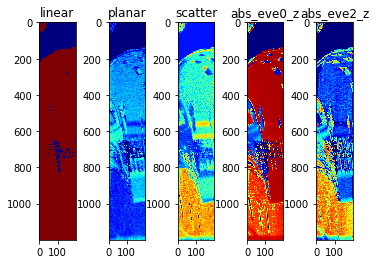

In [20]:
# After execution of the previous cell, run this cell to get a visualization of all features.
feature_names = ["linear", "planar", "scatter", "abs_eve0_z", "abs_eve2_z" ]

fig, axs = plt.subplots(1, 5)
for i, ax in enumerate(axs):
    feat_strip = np.zeros((max_row, max_col), dtype=np.float32)
    feat_strip[valid_mask[:max_row, :max_col]] = features[:,i]
    ax.imshow(feat_strip, cmap="jet", interpolation="nearest")
    ax.set_title(feature_names[i])

## Third part: apply it to the entire scan strip
This may take several minutes, but once you computed the features, you will not have to run this again.

(To watch the progress, one option is that you print out some text or count, e.g. with every 10.000th processed point, in your implementation of `compute_all_features()`.)

In [22]:
# Once we have computed the features for the entire strip, we will store it in the current
# directory. If the cell is executed again, we will just load the stored file. Therefore, if the implementation
# has been wrong and the features need to be re-computed, you would have to delete the file to enforce that.
import os
if os.path.exists("feature_strip.npy"):
    print("INFO: loading feature_strip.npy from file. To enforce re-calculation, delete the file.")
    feature_strip = np.load("feature_strip.npy")
else:
    xyz = scanstrip_data[0:3, valid_mask].T
    features = compute_all_features(xyz)
    feature_strip = np.zeros((5,) + scanstrip_data.shape[1:], dtype=np.float32)
    feature_strip[:, valid_mask] = features.T
    np.save("feature_strip.npy", feature_strip)

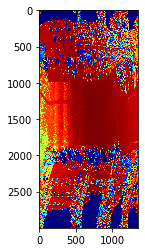

In [23]:
# Just out of curiosity, plot the abs_eve0_z feature. Should be large on the road and small on walls.
plt.imshow(feature_strip[3], cmap="jet", interpolation="nearest");

# The final task: train and test, with the new features, on good training data
Now you should go back to CloudCompare to improve the labeling. Load the `demo_labels.ply` file, and generate more perfect labels. Then, save the labeling result as PLY file, using the filename `ground_truth.ply`.

Remember:
- when you *load* the data into CloudCompare, select at least 'label', 'strip_row', and 'strip_column', as otherwise, the data can't be read back, and
- when you *save* the data from CloudCompare to disk, save it as 'PLY' (binary), with the filename `ground_truth.ply`.

Then, run the following cells to read it back and run the classification.

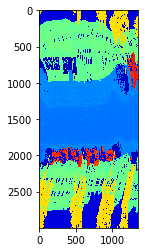

In [24]:
# After generating better training data by labelling in CloudCompare, and saving them as 'ground_truth.ply',
# Run this cell to load and visualize your labels.
r, c, l = read_back_labels_from_ply_file("ground_truth.ply")
ground_truth_labels = np.zeros(scanstrip_data.shape[1:], dtype=np.int16)
ground_truth_labels[r,c] = l
# Create a simple visual overlay by adding a little bit of 'reflectance' to the class label.
plt.imshow(ground_truth_labels + scanstrip_data[3]*0.0002, cmap="jet", interpolation="nearest");

In [25]:
# Here we repeat all steps of the classification from above.
labeled_mask = ground_truth_labels > 0

# Build X from the last two channels of scanstrip_data (reflectance, rel_height),
# and all channels of feature_strip, for a total of n x 7.
X = np.vstack((scanstrip_data[3:5, labeled_mask], feature_strip[:, labeled_mask])).T

# y is the ground truth labels.
y = ground_truth_labels[labeled_mask]

# Now the remaining part is up to you... do everything that is needed to produce the following variables:
X_test, y_test, scaler, clf = None, None, None, None


### BEGIN SOLUTION



# Scale: scale all attributes.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and test: 30% test size.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Train.
# n_estimators is the number of trees. Set verbose to a smaller number if it is too verbose.
clf = RandomForestClassifier(n_estimators=16, criterion="entropy", n_jobs=-1, verbose=2)
clf.fit(X_train, y_train);  # The actual training process.
clf.score(X_test, y_test)

### END SOLUTION

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 16building tree 2 of 16
building tree 3 of 16

building tree 4 of 16building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16

building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:   25.4s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   26.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.8s finished


0.9524894563963189

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.8s finished


          Class Precision    Recall  F1 score
         ground     0.997     0.999     0.998
       building     0.941     0.944     0.943
           tree     0.868     0.865     0.866
            car     0.933     0.889     0.910


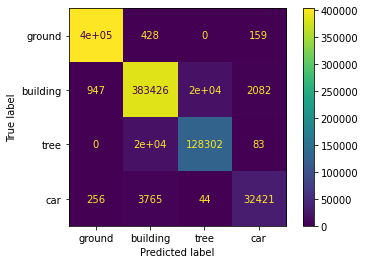

In [26]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
report_prec_recall_f1(y_test, y_pred, clf.classes_, class_names)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    2.5s finished


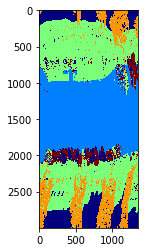

In [27]:
# Do the prediction for the entire scan strip.
X_all = np.vstack((scanstrip_data[3:5, valid_mask], feature_strip[:, valid_mask])).T
X_all = scaler.transform(X_all)  # Transform using the scaler from above.
y_all_pred = clf.predict(X_all)
predicted_labels = np.zeros(scanstrip_data.shape[1:], dtype=np.uint16)
predicted_labels[valid_mask] = y_all_pred
plt.imshow(predicted_labels, cmap="jet", interpolation="nearest");

In [29]:
# Run this to produce a PLY file with predicted_labels.
write_ply_file(scanstrip_data, feature_list = [("label", predicted_labels)],
               ply_filename = "predicted_labels.ply")

<u>Please explain what you learn from this result, compared to the previous result:</u>

The previous result is too good to with 0.9995.  But only using X, Y, Z will usually be not a good idea, because all that happens is that the classifier learns the location of the classes in object space, which will not be useful at all when it comes to generalization.So to improve this situation, except for X,Y,Z we use features which indicate the local structure around each point. The result became lower with 0.9525, but it can be useful when it comes to generalization. And the recognition of objects will also become more accurate.


# Conclusions
Please do a wrap-up of this exercise!

In this exercise, we learned the following:
### BEGIN SOLUTION
- To avoid the useless measurement, we set x=0 and y=0 and z=0, the measurement is invalid.
- How to use CloudCompare to label points in 3D.
- Through the labeled points we can train a calssifier, which is based on X,Y,Z. But it is not representative, if it is used for other scenes, it will make trouble, beacuse the classifier only lerans the location of the classes in object space.
- A good way to train a classifier is through features, so that eigenvalue and eigenvector play very important roll.
- The main features of the object are 'linear, planar, scatter'. We can through the eigenvalues of points cloud to get the feature of objects.
- If we want to get a valid classifier, we should traversal all points of our scan strip. With the help of k-d tree we can quickly get the nearest neighbours within the radius what we want.
- Due to the huge number of dataset, it is not easy to compute all features of dataset, so that we can at first compute a part of the dataset and use only upper left corner of scan strip.
- The result of new classifier, which is based on features, is not so good as the classifier, which is based on X,Y,Z,. But it can be universally used in different scenarios 
- If the correct rate is as high as 100%, we have two conclusions. The first one is, this method is perfect and 100% correct. Second one is, this method has strong limitations. So the score of our solution is not need to close to 100, but over 90 is meanful.

### END SOLUTION